In [63]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load MiniLM (base or distilled variant)
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
model = AutoModel.from_pretrained("microsoft/MiniLM-L12-H384-uncased")

# Encode a sentence
inputs = tokenizer("dog", return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)

# outputs.last_hidden_state has shape: (batch_size, seq_len, hidden_dim)
encodings = outputs.last_hidden_state


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [64]:
from transformers import AutoTokenizer, AutoModel

# Public model — does NOT require a token
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

print("Loaded BERT model successfully.")


Loaded BERT model successfully.


In [65]:
import requests
r = requests.get("https://huggingface.co/google/vit-small-patch16-224")
print("Status Code:", r.status_code)


Status Code: 401


In [66]:
print(encodings.shape)

torch.Size([1, 3, 384])


In [6]:
from getpass import getpass
from huggingface_hub import login, whoami

# Prompt for token securely
hf_token = getpass("🔐 Enter your Hugging Face token: ")

# Log in to Hugging Face
login(token=hf_token)

# Fetch and display user info to confirm
user_info = whoami()
print("✅ Logged in successfully!")
print(f"👤 Username: {user_info['name']}")
print(f"📛 Type: {user_info['type']}")


🔐 Enter your Hugging Face token: ··········
✅ Logged in successfully!
👤 Username: menon123
📛 Type: user


In [68]:
from transformers import ViTImageProcessor, ViTModel
import torch
from PIL import Image
import requests
from io import BytesIO

# Load model + processor
model_name = "google/vit-base-patch16-224-in21k"  # This returns 768-dim by default
model = ViTModel.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

# Load and preprocess image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beach.png"
image_path= "dog.png"
image = Image.open(image_path).convert("RGB")
inputs = processor(images=image, return_tensors="pt")

# Get embeddings
with torch.no_grad():
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
projector = torch.nn.Linear(768, 384)
embedding_384 = projector(cls_embedding)

print("384-dimensional embedding shape:", embedding_384.shape)


384-dimensional embedding shape: torch.Size([1, 384])


In [69]:
import torch
import torch.nn as nn

class BottleneckAttention(nn.Module):
    def __init__(self, dim=384, num_heads=6, num_bottlenecks=4):
        super().__init__()
        self.bottleneck_tokens = nn.Parameter(torch.randn(1, num_bottlenecks, dim))
        self.cross_attn_img = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.cross_attn_txt = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

    def forward(self, image_tokens, text_tokens):
        B = image_tokens.shape[0]

        # Expand bottleneck tokens to batch size
        bottlenecks = self.bottleneck_tokens.expand(B, -1, -1)  # [B, B₀, D]

        # --- Step 1: Tokens → Bottlenecks (Tokens attend to bottlenecks)
        # Image attends to bottlenecks
        img_out, _ = self.cross_attn_img(query=image_tokens, key=bottlenecks, value=bottlenecks)

        # Text attends to bottlenecks
        txt_out, _ = self.cross_attn_txt(query=text_tokens, key=bottlenecks, value=bottlenecks)

        # --- Step 2: Bottlenecks → Tokens (Bottlenecks attend to each modality)
        # Bottlenecks attend to image
        bn_img, _ = self.cross_attn_img(query=bottlenecks, key=img_out, value=img_out)

        # Bottlenecks attend to text
        bn_txt, _ = self.cross_attn_txt(query=bottlenecks, key=txt_out, value=txt_out)

        # Combine (optional: sum, cat, etc.)
        fused = bn_img + bn_txt  # [B, B₀, D]

        return fused


In [70]:
# Dummy inputs for testing (remove these if using real embeddings)
batch_size = 1
image_tokens = embedding_384.unsqueeze(0)
text_tokens = encodings
print(image_tokens.shape)
print (text_tokens.shape)

# Initialize and run the model
model = BottleneckAttention(dim=384, num_heads=6, num_bottlenecks=4)
fused_output = model(image_tokens, text_tokens)

# Convert for visualization
bottleneck_tokens = fused_output[0].detach().cpu().numpy()
text_embeddings = text_tokens.squeeze(0).detach().cpu().numpy()
image_embeddings = image_tokens.squeeze(0).detach().cpu().numpy()

print("Bottleneck shape:", bottleneck_tokens.shape)
print("Text shape:", text_embeddings.shape)
print("Image shape:", image_embeddings.shape)


torch.Size([1, 1, 384])
torch.Size([1, 3, 384])
Bottleneck shape: (4, 384)
Text shape: (3, 384)
Image shape: (1, 384)


In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckCrossAttention(nn.Module):
    def __init__(self, dim, bottleneck_tokens=16, num_heads=4):
        super().__init__()
        self.bottleneck = nn.Parameter(torch.randn(1, bottleneck_tokens, dim))
        self.cross_attn_text = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.cross_attn_image = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, text_emb, image_emb):
      import torch

      if not isinstance(text_emb, torch.Tensor):
            text_emb = torch.tensor(text_emb, dtype=torch.float32)

      B = text_emb.size(0)
      b_tokens = self.bottleneck.expand(B, -1, -1)

        # Bottleneck attends to text
      b_to_text, _ = self.cross_attn_text(b_tokens, text_emb, text_emb)

        # Bottleneck attends to image
      b_to_image, _ = self.cross_attn_image(b_to_text, image_emb, image_emb)

      return b_to_image


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarities_heatmap(b_tokens, text_emb, image_emb, epoch):
    sim_bt = cosine_similarity(b_tokens.detach().cpu().numpy(), text_emb.detach().cpu().numpy())
    sim_bv = cosine_similarity(b_tokens.detach().cpu().numpy(), image_emb.detach().cpu().numpy())

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    sns.heatmap(sim_bt, ax=axes[0], cmap="viridis")
    axes[0].set_title(f"Bottleneck vs Text Similarity (Epoch {epoch})")

    sns.heatmap(sim_bv, ax=axes[1], cmap="viridis")
    axes[1].set_title(f"Bottleneck vs Image Similarity (Epoch {epoch})")
    plt.tight_layout()
    plt.show()


Epoch 1, Loss: -0.3059


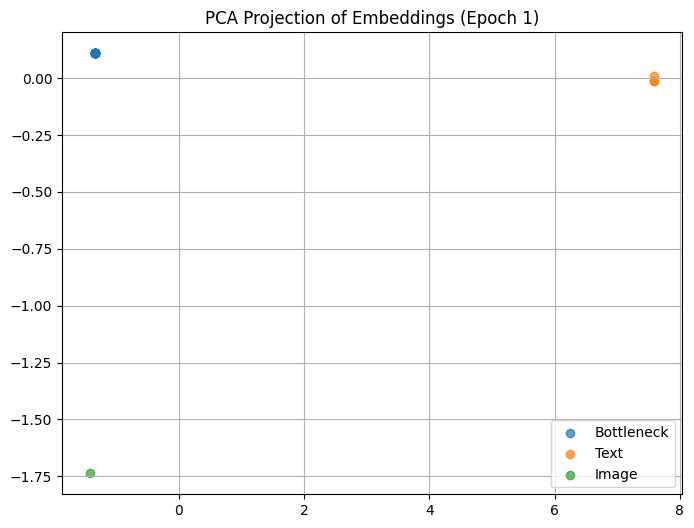

Epoch 2, Loss: -3.9808


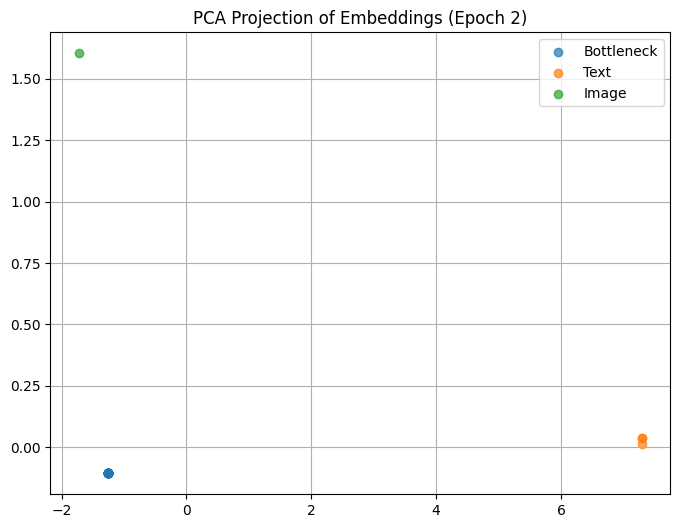

Epoch 3, Loss: -7.9508


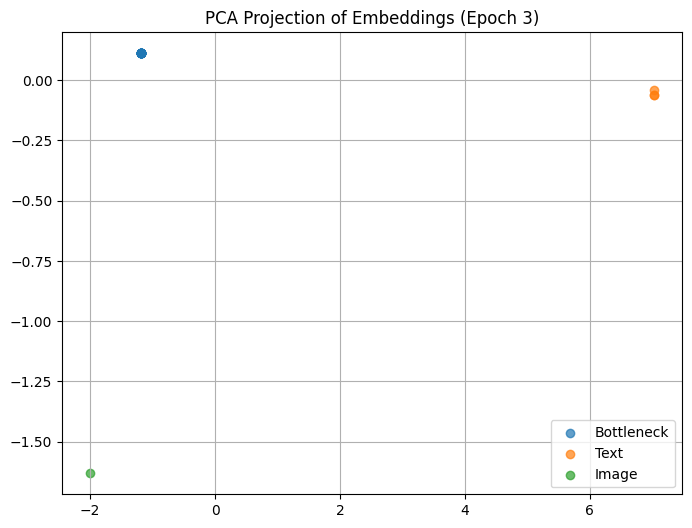

Epoch 4, Loss: -12.5546


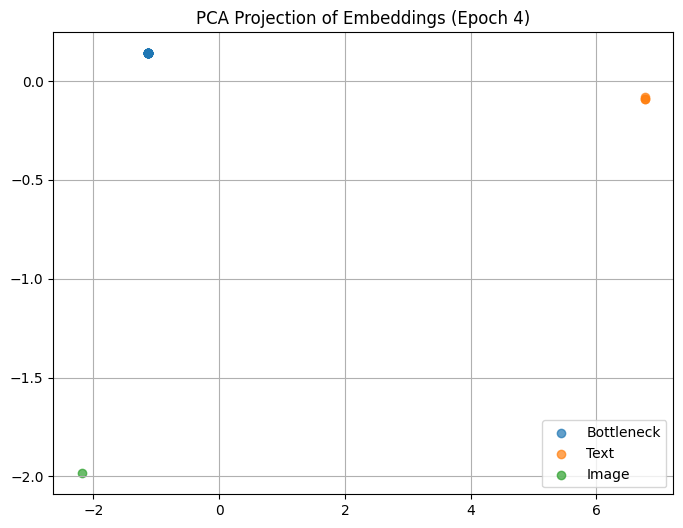

Epoch 5, Loss: -18.0345


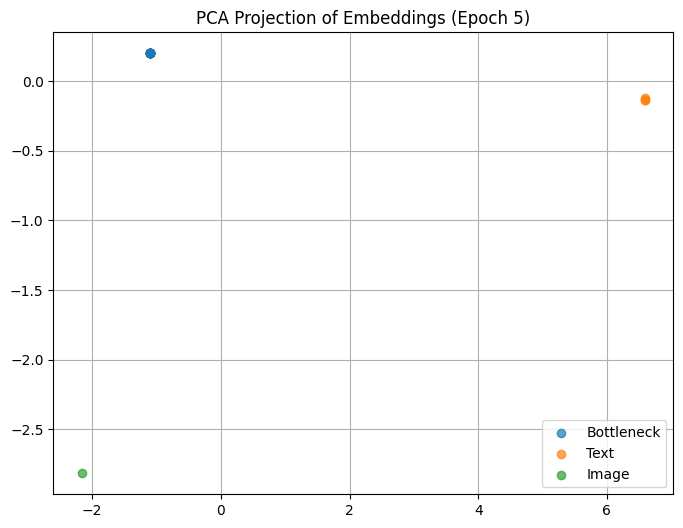

Epoch 6, Loss: -24.5537


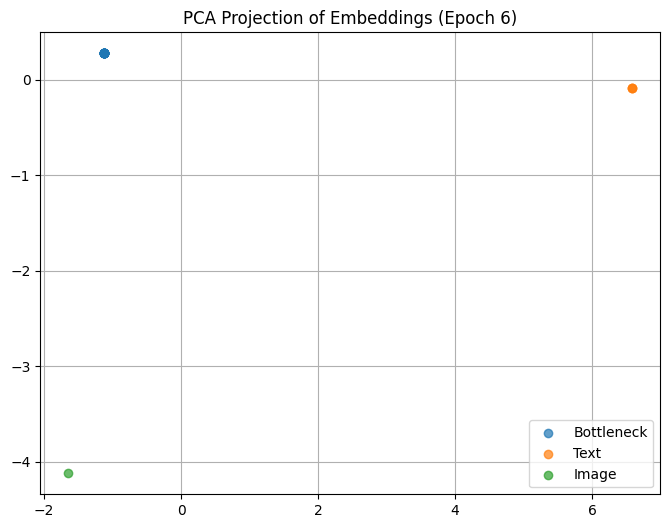

Epoch 7, Loss: -32.2296


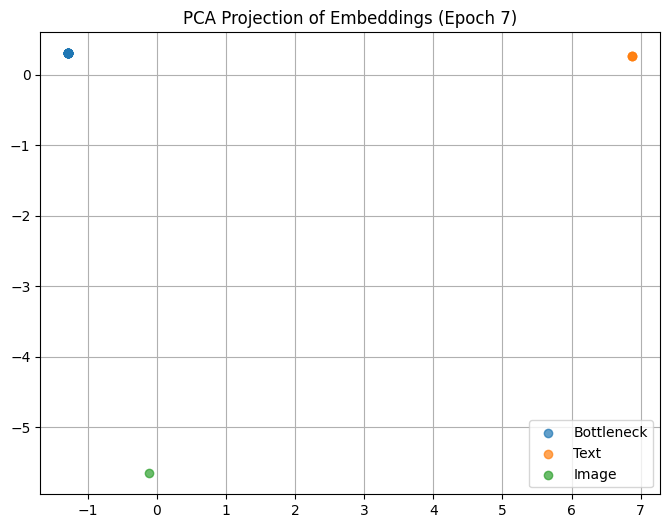

Epoch 8, Loss: -41.1546


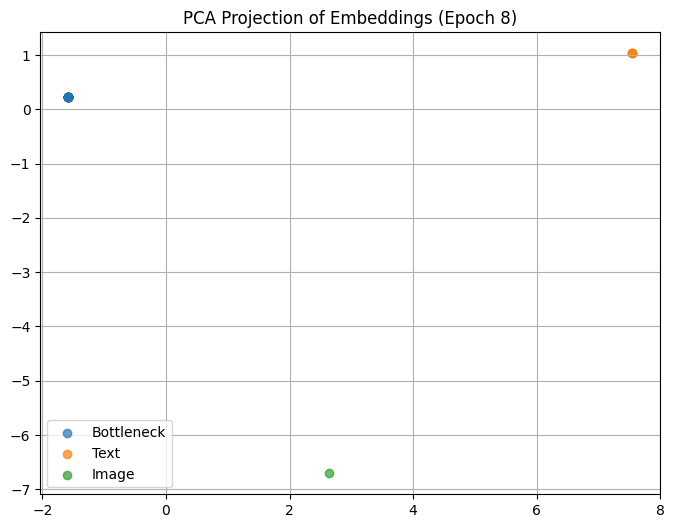

Epoch 9, Loss: -51.4056


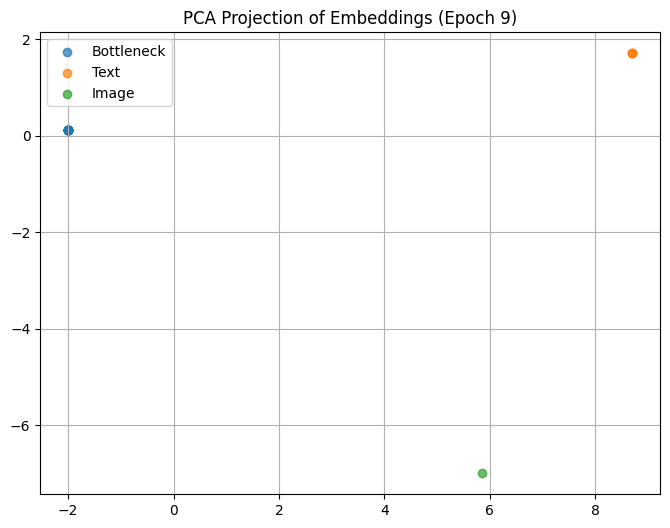

Epoch 10, Loss: -63.0514


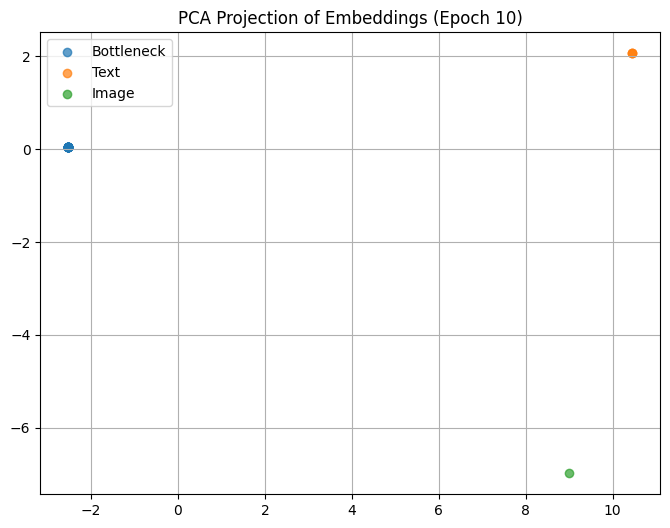

In [73]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure you're on CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume you already have these from previous steps
# fused_output, text_tokens, image_tokens

model = BottleneckCrossAttention(dim=384, bottleneck_tokens=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Convert to torch.Tensor
bottleneck_tokens = fused_output[0].detach().to(device)        # (16, 384)
text_embeddings = text_tokens.squeeze(0).detach().to(device)   # (N, 384)
image_embeddings = image_tokens.squeeze(0).detach().to(device) # (M, 384)

# --- Define plot helper ---
from sklearn.decomposition import PCA

def plot_similarities(bottleneck, text, image, epoch):
    b = bottleneck.detach().cpu().numpy()
    t = text.detach().cpu().numpy()
    v = image.detach().cpu().numpy()

    all_embeddings = np.vstack([b, t, v])
    labels = (
        ["Bottleneck"] * len(b) +
        ["Text"] * len(t) +
        ["Image"] * len(v)
    )

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_embeddings)

    plt.figure(figsize=(8, 6))
    for label in ["Bottleneck", "Text", "Image"]:
        idxs = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=label, alpha=0.7)

    plt.title(f"PCA Projection of Embeddings (Epoch {epoch})")
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Training loop ---
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    text_emb = text_embeddings.unsqueeze(0)   # (1, N, 384)
    image_emb = image_embeddings.unsqueeze(0) # (1, M, 384)
    b_out = model(text_emb, image_emb)        # (1, 16, 384)

    # Mean of embeddings
    # Normalize for cosine similarity
    b_norm = F.normalize(b_out, dim=-1)
    t_norm = F.normalize(text_tokens, dim=-1)
    v_norm = F.normalize(image_tokens, dim=-1)

      # Compute full cosine similarity matrix between bottleneck and text/image
    sim_bt = torch.bmm(b_out, text_emb.transpose(1, 2))  # shape: [1, 16, 20]
    sim_bi = torch.bmm(b_out, image_emb.transpose(1, 2)) # shape: [1, 16, 20]

    loss_bt = -sim_bt.mean()
    loss_bi = -sim_bi.mean()
    loss = (loss_bt + loss_bi)




    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Visualization
    plot_similarities(b_out[0], text_embeddings, image_embeddings, epoch+1)


In [74]:
# import torch
# import torch.nn as nn

# class BottleneckAttention(nn.Module):
#     def __init__(self, dim=384, num_heads=6, num_bottlenecks=4):
#         super().__init__()
#         self.bottleneck_tokens = nn.Parameter(torch.randn(1, num_bottlenecks, dim))
#         self.cross_attn_img = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
#         self.cross_attn_txt = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

#     def forward(self, image_tokens, text_tokens):
#         B = image_tokens.shape[0]

#         # Expand bottleneck tokens to batch size
#         bottlenecks = self.bottleneck_tokens.expand(B, -1, -1)  # [B, B₀, D]

#         # --- Step 1: Tokens → Bottlenecks (Tokens attend to bottlenecks)
#         # Image attends to bottlenecks
#         img_out, _ = self.cross_attn_img(query=image_tokens, key=bottlenecks, value=bottlenecks)

#         # Text attends to bottlenecks
#         txt_out, _ = self.cross_attn_txt(query=text_tokens, key=bottlenecks, value=bottlenecks)

#         # --- Step 2: Bottlenecks → Tokens (Bottlenecks attend to each modality)
#         # Bottlenecks attend to image
#         bn_img, _ = self.cross_attn_img(query=bottlenecks, key=img_out, value=img_out)

#         # Bottlenecks attend to text
#         bn_txt, _ = self.cross_attn_txt(query=bottlenecks, key=txt_out, value=txt_out)

#         # Combine (optional: sum, cat, etc.)
#         fused = bn_img + bn_txt  # [B, B₀, D]

#         return fused

# import torch
# import torch.nn as nn

# # Define the bottleneck cross-attention module
# class BottleneckAttention(nn.Module):
#     def __init__(self, dim=384, num_heads=6, num_bottlenecks=4):
#         super().__init__()
#         self.bottleneck_tokens = nn.Parameter(torch.randn(1, num_bottlenecks, dim))
#         self.cross_attn_img = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
#         self.cross_attn_txt = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

#     def forward(self, image_tokens, text_tokens):
#         B = image_tokens.shape[0]
#         bottlenecks = self.bottleneck_tokens.expand(B, -1, -1)  # [B, B₀, D]

#         # Step 1: Image and text attend to bottlenecks
#         img_attended, _ = self.cross_attn_img(query=image_tokens, key=bottlenecks, value=bottlenecks)
#         txt_attended, _ = self.cross_attn_txt(query=text_tokens, key=bottlenecks, value=bottlenecks)

#         # Step 2: Bottlenecks attend back to attended image/text
#         bn_img, _ = self.cross_attn_img(query=bottlenecks, key=img_attended, value=img_attended)
#         bn_txt, _ = self.cross_attn_txt(query=bottlenecks, key=txt_attended, value=txt_attended)

#         # Combine bottleneck outputs
#         fused = bn_img + bn_txt  # or torch.cat([...], dim=-1)
#         return fused

# # Dummy input: batch of 1, 10 image tokens, 20 text tokens, all of dim 384
# batch_size = 1

# # Initialize and run the model
# model = BottleneckAttention(dim=384, num_heads=6, num_bottlenecks=4)
# fused_output = model(image_tokens, text_tokens)

# # Output
# print("Fused output shape:", fused_output.shape)
# print("Fused output sample:\n", fused_output[0])

# bottleneck_tokens = fused_output[0].detach().cpu().numpy()  # shape: (num_bottlenecks, 384)
# text_embeddings = text_tokens.squeeze(0).detach().cpu().numpy()     # shape: (num_text_tokens, 384)
# image_embeddings = image_tokens.squeeze(0).detach().cpu().numpy()   # shape: (num_image_tokens, 384)
# print(bottleneck_tokens.shape)
# print(text_embeddings.shape)
# print(image_embeddings.shape)


# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BottleneckCrossAttention(nn.Module):
#     def __init__(self, dim, bottleneck_tokens=16, num_heads=4):
#         super().__init__()
#         self.bottleneck = nn.Parameter(torch.randn(1, bottleneck_tokens, dim))
#         self.cross_attn_text = nn.MultiheadAttention(dim, num_heads, batch_first=True)
#         self.cross_attn_image = nn.MultiheadAttention(dim, num_heads, batch_first=True)

#     def forward(self, text_emb, image_emb):
#       import torch

#       if not isinstance(text_emb, torch.Tensor):
#             text_emb = torch.tensor(text_emb, dtype=torch.float32)

#       B = text_emb.size(0)
#       b_tokens = self.bottleneck.expand(B, -1, -1)

#         # Bottleneck attends to text
#       b_to_text, _ = self.cross_attn_text(b_tokens, text_emb, text_emb)

#         # Bottleneck attends to image
#       b_to_image, _ = self.cross_attn_image(b_to_text, image_emb, image_emb)

#       return b_to_image


# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics.pairwise import cosine_similarity

# def plot_similarities(b_tokens, text_emb, image_emb, epoch):
#     sim_bt = cosine_similarity(b_tokens.detach().cpu().numpy(), text_emb.detach().cpu().numpy())
#     sim_bv = cosine_similarity(b_tokens.detach().cpu().numpy(), image_emb.detach().cpu().numpy())

#     fig, axes = plt.subplots(2, 1, figsize=(8, 8))
#     sns.heatmap(sim_bt, ax=axes[0], cmap="viridis")
#     axes[0].set_title(f"Bottleneck vs Text Similarity (Epoch {epoch})")

#     sns.heatmap(sim_bv, ax=axes[1], cmap="viridis")
#     axes[1].set_title(f"Bottleneck vs Image Similarity (Epoch {epoch})")
#     plt.tight_layout()
#     plt.show()


# import torch
# import torch.nn.functional as F
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Ensure you're on CPU or GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Assume you already have these from previous steps
# # fused_output, text_tokens, image_tokens

# model = BottleneckCrossAttention(dim=384, bottleneck_tokens=16).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # Convert to torch.Tensor
# bottleneck_tokens = fused_output[0].detach().to(device)        # (16, 384)
# text_embeddings = text_tokens.squeeze(0).detach().to(device)   # (N, 384)
# image_embeddings = image_tokens.squeeze(0).detach().to(device) # (M, 384)

# # --- Define plot helper ---
# from sklearn.decomposition import PCA

# def plot_similarities(bottleneck, text, image, epoch):
#     b = bottleneck.detach().cpu().numpy()
#     t = text.detach().cpu().numpy()
#     v = image.detach().cpu().numpy()

#     all_embeddings = np.vstack([b, t, v])
#     labels = (
#         ["Bottleneck"] * len(b) +
#         ["Text"] * len(t) +
#         ["Image"] * len(v)
#     )

#     pca = PCA(n_components=2)
#     reduced = pca.fit_transform(all_embeddings)

#     plt.figure(figsize=(8, 6))
#     for label in ["Bottleneck", "Text", "Image"]:
#         idxs = [i for i, l in enumerate(labels) if l == label]
#         plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=label, alpha=0.7)

#     plt.title(f"PCA Projection of Embeddings (Epoch {epoch})")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # --- Training loop ---
# epochs = 10
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     text_emb = text_embeddings.unsqueeze(0)   # (1, N, 384)
#     image_emb = image_embeddings.unsqueeze(0) # (1, M, 384)
#     b_out = model(text_emb, image_emb)        # (1, 16, 384)

#     # Mean of embeddings
#     b_mean = b_out.mean(dim=1)      # (1, 384)
#     t_mean = text_emb.mean(dim=1)   # (1, 384)
#     v_mean = image_emb.mean(dim=1)  # (1, 384)

#     # Loss: similarity to both text and image
#     loss = -F.cosine_similarity(b_mean, t_mean, dim=1).mean()
#     loss += -F.cosine_similarity(b_mean, v_mean, dim=1).mean()

#     loss.backward()
#     optimizer.step()

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

#     # Visualization
#     plot_similarities(b_out[0], text_embeddings, image_embeddings, epoch+1)


# i seem to have made an absolute mess of things can you fix it this is all the code after creating embeddings